In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_B_over"
plot_title = "train_B_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.777435,0.779264,0.777400,0.779264,0.929557,0.930552,0.869504,0.866955
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.829172,0.829431,0.829160,0.829431,0.951683,0.951897,0.912094,0.910669
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.854793,0.854849,0.854784,0.854849,0.958409,0.958664,0.924658,0.924125
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.868752,0.868896,0.868742,0.868896,0.962485,0.963068,0.932771,0.932690
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.868205,0.868227,0.868194,0.868227,0.965010,0.965615,0.936787,0.938217


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.817126,0.803479,0.680558,0.803479,0.930965,0.905736,0.886884,0.793462
1,2,test,0.830619,0.816366,0.710590,0.816366,0.938794,0.929674,0.898213,0.843851
2,3,test,0.850693,0.839562,0.739861,0.839562,0.946836,0.936540,0.909564,0.857603
3,4,test,0.865348,0.857603,0.758369,0.857603,0.957402,0.941024,0.925947,0.865320
4,5,test,0.846009,0.833763,0.736491,0.833763,0.946258,0.940345,0.906971,0.863969


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/302:,Train,Loss,=,1.209,Valid,Loss,=,1.172,ETA,=,4.70h
1,Epoch,"1/40,",Batch,20/302:,Train,Loss,=,1.173,Valid,Loss,=,1.118,ETA,=,4.58h
2,Epoch,"1/40,",Batch,30/302:,Train,Loss,=,1.108,Valid,Loss,=,1.087,ETA,=,4.22h
3,Epoch,"1/40,",Batch,40/302:,Train,Loss,=,1.056,Valid,Loss,=,1.035,ETA,=,4.05h
4,Epoch,"1/40,",Batch,50/302:,Train,Loss,=,1.066,Valid,Loss,=,1.004,ETA,=,3.94h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.209,1.172
20,1,20,1.173,1.118
30,1,30,1.108,1.087
40,1,40,1.056,1.035
50,1,50,1.066,1.004


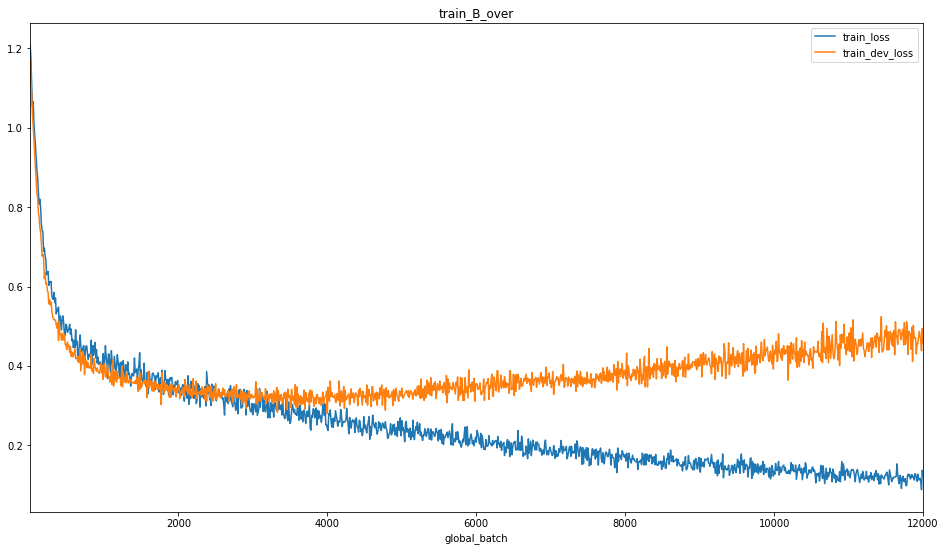

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.778,0.7230
2,0.505,0.4650
3,0.443,0.4085
4,0.407,0.3835
5,0.383,0.3620


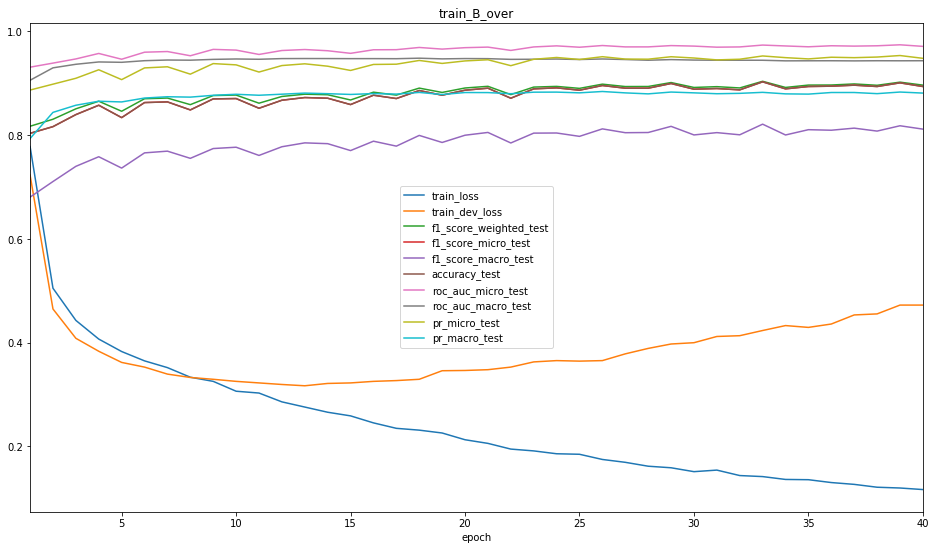

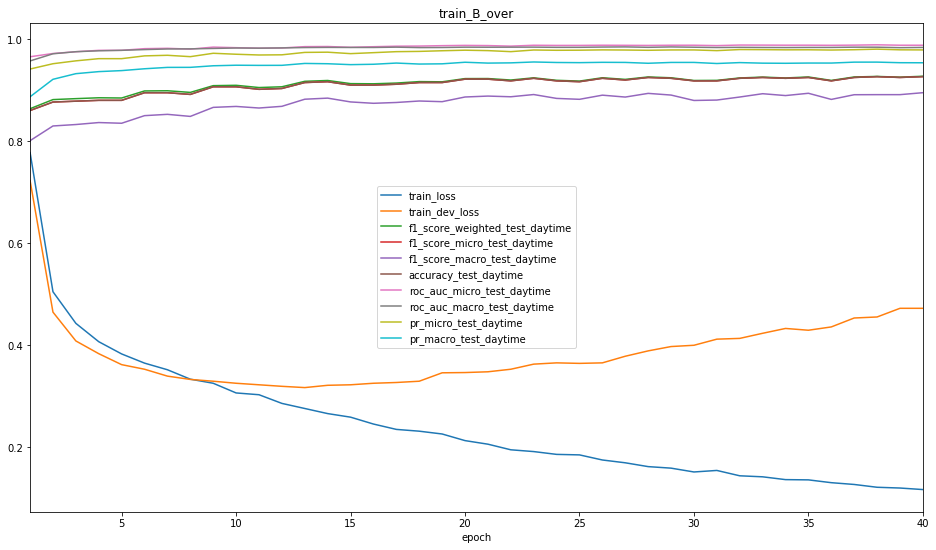

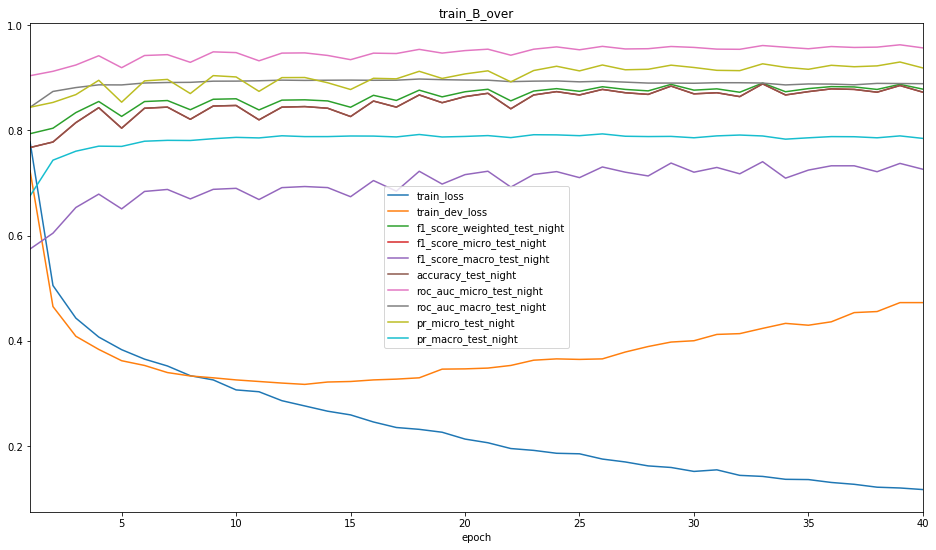

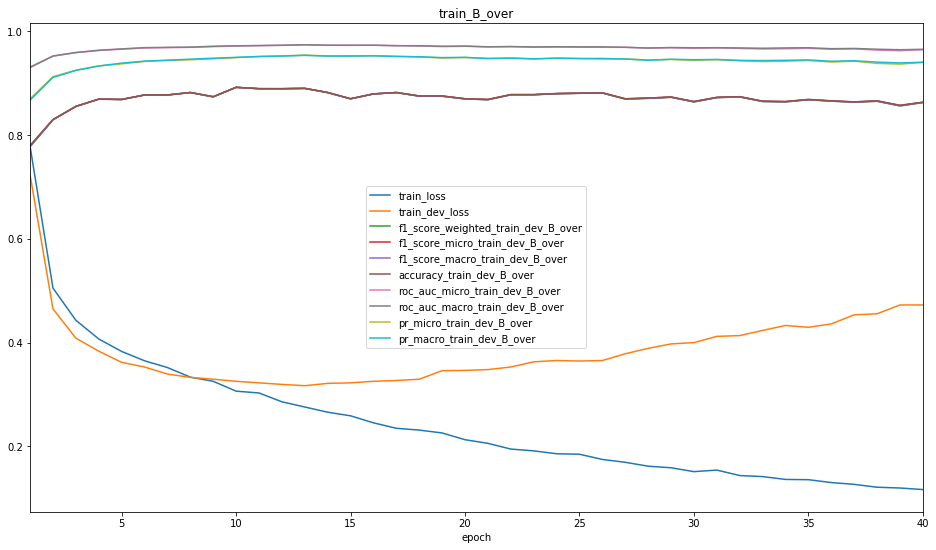

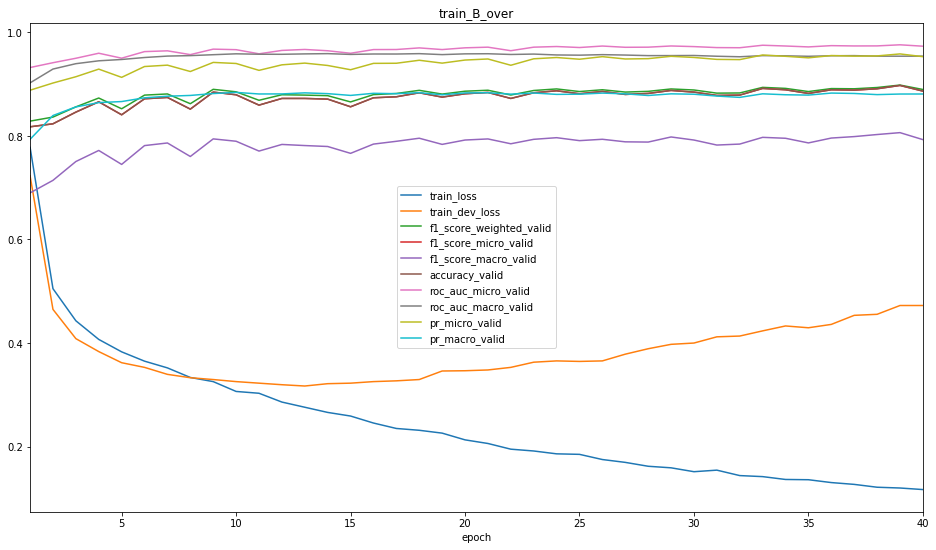

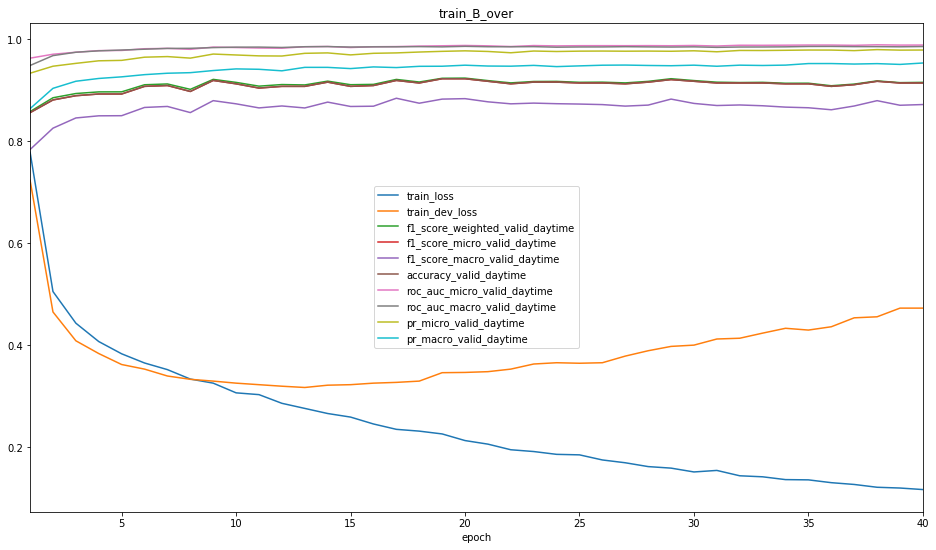

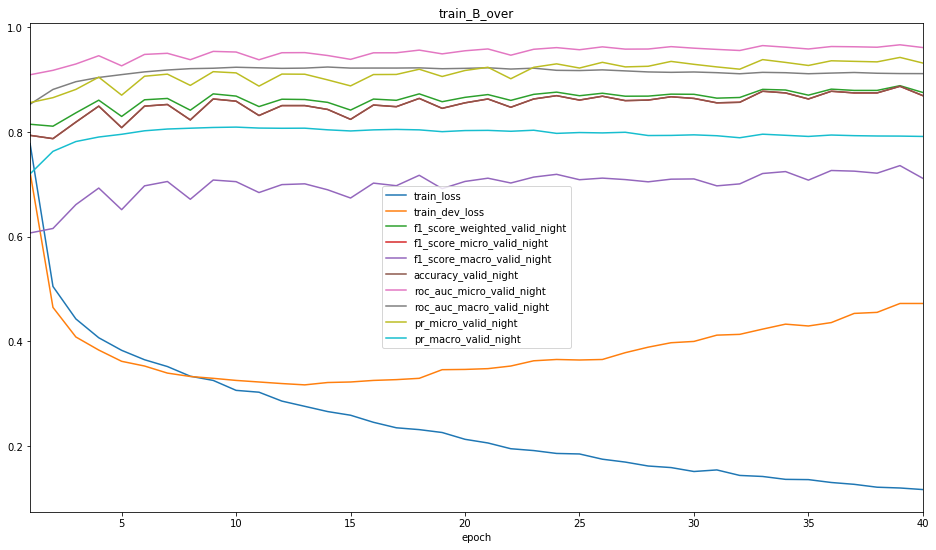

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)